In [4]:
!pip install scikit-learn

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import scipy.sparse
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Preprocessing

In [6]:
# Read the CSV file
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('dev.csv')

# Preprocessingn
english_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_and_lemmatize(word):
    if pd.isnull(word):
        return [], ""
    document_words = re.sub('[^a-zA-Z]', ' ', word)  # Remove non-alphabetical characters
    document_words = document_words.lower()          # Case-folding
    document_words = nltk.word_tokenize(document_words)  # Tokenization
    document_words = [lemmatizer.lemmatize(w) for w in document_words if w not in english_stopwords]  # Remove stopwords and lemmatize
    return document_words, ' '.join(document_words)  # Return both list of tokens and the combined string


# Assuming the label column in your CSV is binary (1 or 0), convert it to 'entailment' and 'contradiction'
train_data['label'] = train_data['label'].map({1: 'entailment', 0: 'contradiction'})
test_data['label'] = test_data['label'].map({1: 'entailment', 0: 'contradiction'})

# Preprocess and update DataFrame for both 'premise' and 'hypothesis' in training and testing data
for df in [train_data, test_data]:
    df['premise_processed'] = df['premise'].apply(lambda x: preprocess_and_lemmatize(x)[1])
    df['hypothesis_processed'] = df['hypothesis'].apply(lambda x: preprocess_and_lemmatize(x)[1])

# Convert DataFrame to the format required by your code
train_data_formatted = [train_data['premise'].values, train_data['hypothesis'].values, train_data['label'].values]
test_data_formatted = [test_data['premise'].values, test_data['hypothesis'].values, test_data['label'].values]

# Defining the Model


In [10]:
def TFIDF_features(data, mode):
    list_sentence1 = data[0]
    list_sentence2 = data[1]
    list_gold_label = data[2]
    corpus_sentence1 = [' '.join(str(item).split()) for item in list_sentence1]
    corpus_sentence2 = [' '.join(str(item).split()) for item in list_sentence2]

    num_samples = len(list_gold_label)

    corpus = [corpus_sentence1[ind] + " " + corpus_sentence2[ind] for ind in range(num_samples)]

    tfidf_labels = [None] * num_samples
    for ind, item in enumerate(list_gold_label):
        if item == "contradiction":
            tfidf_labels[ind] = 0
        elif item == "entailment":
            tfidf_labels[ind] = 1

    if mode == "train":
        TFIDF_vect = TfidfVectorizer()
        TFIDF_vect.fit(corpus)
        with open('TFIDF.pickle', "wb") as file:
            pickle.dump(TFIDF_vect, file)
    elif mode == "test":
        with open('TFIDF.pickle', "rb") as file:
            TFIDF_vect = pickle.load(file)
    else:
        print("Invalid mode selection")
        exit(0)

    tfidf_sentecnce1 = TFIDF_vect.transform(corpus_sentence1)
    tfidf_sentecnce2 = TFIDF_vect.transform(corpus_sentence2)

    tfidf_feature_array = scipy.sparse.hstack((tfidf_sentecnce1, tfidf_sentecnce2))

    return tfidf_feature_array, tfidf_labels


# Training

In [5]:
def logistic_regression_train(train_data):
    train_feature, train_label = TFIDF_features(train_data, "train")

    LR_model = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', multi_class='auto')
    LR_model.fit(train_feature, train_label)

    with open('LR.pickle', "wb") as file:
        pickle.dump(LR_model, file)

    print("Training complete.\n")


In [6]:
logistic_regression_train(train_data_formatted)

Training complete.



# Evaluation


In [7]:
test_data_formatted = [test_data['premise'].values, test_data['hypothesis'].values, test_data['label'].values]

In [8]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns


# logistic_regression_test function
def logistic_regression_test(test_data):
    # Obtain the TFIDF features
    test_feature, test_label = TFIDF_features(test_data, "test")

    # Load the logistic regression model from the pickle file
    with open('LR.pickle', "rb") as file:
        LR_model = pickle.load(file)

    # Test the logistic regression model
    pred_labels = LR_model.predict(test_feature)

    predictions_df = pd.DataFrame(pred_labels, columns=['prediction'])

    # Save predictions to a CSV file
    predictions_df.to_csv('./predictions.csv', index=False)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_label, pred_labels, average="macro"
    )

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(test_label, pred_labels)

    # Evaluate and print the results
    score = LR_model.score(test_feature, test_label) * 100

    print("The classification accuracy for Logistic regression with TF-IDF features is {:.2f}%.".format(score))
    # Print precision, recall, F1-score, and classification report
    print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print("\n\nClassification Report:")
    print(classification_report(test_label, pred_labels))


     # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=['contradiction', 'entailment'], yticklabels=['contradiction', 'entailment']
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


The classification accuracy for Logistic regression with TF-IDF features is 65.41%.

Precision: 0.6543, Recall: 0.6524, F1-score: 0.6522


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      3259
           1       0.65      0.71      0.68      3478

    accuracy                           0.65      6737
   macro avg       0.65      0.65      0.65      6737
weighted avg       0.65      0.65      0.65      6737



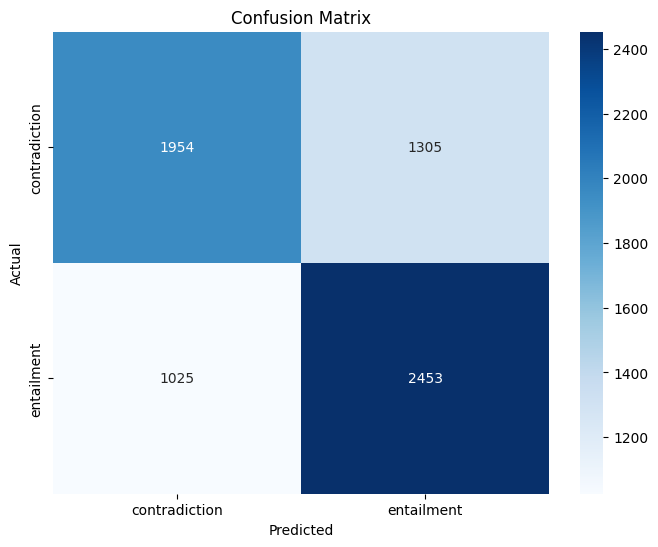

In [12]:
# Evaluate the model on the test data
logistic_regression_test(test_data_formatted)